# Import modules

We probably need all the same stuff used in the simulation, plus matplotlib. I don't know this for sure, but I think it is true because I was lazy and used pickle instead of coming up with a data structure.

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import itertools
from copy import deepcopy,copy
import numpy as np
import multiprocessing as mp
import pickle
import glob
import pandas as pd

##Fwdpy and libsequence
import fwdpy11 as fp11 #fwdpy11 
from fwdpy11.model_params import SlocusParams
import fwdpy11.wright_fisher as wf
import fwdpy11.sampling as fps
import libsequence.polytable as polyt
from libsequence.summstats import PolySIM

#My stuff
import clonal  #This is my fwdpy11 extension module for clonal evolution
import RecordStats # My recorder class



# Read in pickled data


In [2]:
rec_files=glob.glob('data/recessive/recessive_clonal_grape*.pkl')
add_files=glob.glob('data/additive/additive_clonal_grape*.pkl')

rec_files[0]
add_files[0]

disc_rec_files=glob.glob('data/disc_recessive/disc_recessive_clonal_grape*.pkl')
disc_add_files=glob.glob('data/disc_additive/disc_additive_clonal_grape*.pkl')

disc_rec_files[0]
disc_add_files[0]

'data/disc_additive/disc_additive_clonal_grape.206.pkl'

In [3]:
rec_pkl_data = [pickle.load(open(i,'rb')) for i in rec_files]
add_pkl_data = [pickle.load(open(i,'rb')) for i in add_files]
disc_rec_pkl_data = [pickle.load(open(i,'rb')) for i in disc_rec_files]
disc_add_pkl_data = [pickle.load(open(i,'rb')) for i in disc_add_files]


# Population size history

In [4]:
rec_pkl_data[0]['ancestral'].neutral_pi[319]

37.81070707070713

In [52]:
exp_decl = np.uint32(np.exp(np.linspace(np.log(4000),np.log(200.5),100)))
exp_decl[0:73]

array([3999, 3880, 3765, 3653, 3544, 3438, 3336, 3237, 3140, 3047, 2956,
       2868, 2782, 2699, 2619, 2541, 2465, 2392, 2321, 2252, 2184, 2119,
       2056, 1995, 1936, 1878, 1822, 1768, 1715, 1664, 1614, 1566, 1520,
       1474, 1430, 1388, 1346, 1306, 1267, 1230, 1193, 1157, 1123, 1090,
       1057, 1026,  995,  965,  937,  909,  882,  855,  830,  805,  781,
        758,  735,  713,  692,  671,  651,  632,  613,  595,  577,  560,
        543,  527,  511,  496,  481,  467,  453], dtype=uint32)

In [53]:
exp_decl[73:100]

array([440, 426, 414, 401, 389, 378, 367, 356, 345, 335, 325, 315, 306,
       297, 288, 279, 271, 263, 255, 247, 240, 233, 226, 219, 212, 206, 200], dtype=uint32)

In [54]:
exp_decl

array([3999, 3880, 3765, 3653, 3544, 3438, 3336, 3237, 3140, 3047, 2956,
       2868, 2782, 2699, 2619, 2541, 2465, 2392, 2321, 2252, 2184, 2119,
       2056, 1995, 1936, 1878, 1822, 1768, 1715, 1664, 1614, 1566, 1520,
       1474, 1430, 1388, 1346, 1306, 1267, 1230, 1193, 1157, 1123, 1090,
       1057, 1026,  995,  965,  937,  909,  882,  855,  830,  805,  781,
        758,  735,  713,  692,  671,  651,  632,  613,  595,  577,  560,
        543,  527,  511,  496,  481,  467,  453,  440,  426,  414,  401,
        389,  378,  367,  356,  345,  335,  325,  315,  306,  297,  288,
        279,  271,  263,  255,  247,  240,  233,  226,  219,  212,  206,
        200], dtype=uint32)

In [43]:
generations = rec_pkl_data[0]['ancestral'].generation + rec_pkl_data[0]['const_outcross'].generation
ancestral_N = rec_pkl_data[0]['ancestral'].N
const_N = ancestral_N +  rec_pkl_data[0]['const_outcross'].N
decline_N = ancestral_N + rec_pkl_data[0]['bottle_outcross'].N
bottle_N = ancestral_N + disc_rec_pkl_data[0]['bottle_outcross'].N
exp_N  = np.hstack( [ancestral_N,np.uint32(np.exp(np.linspace(np.log(4000),np.log(200.5),100)))])


In [5]:
def scale_time(gen,maxgen,N):
    st = [(i - maxgen)/(2.0*N) for i in gen]
    return(st)


In [6]:
scaled_time = scale_time(generations,
                               np.max(generations),
                               np.max(const_N))

deltaN = len(const_N) - len(ancestral_N)


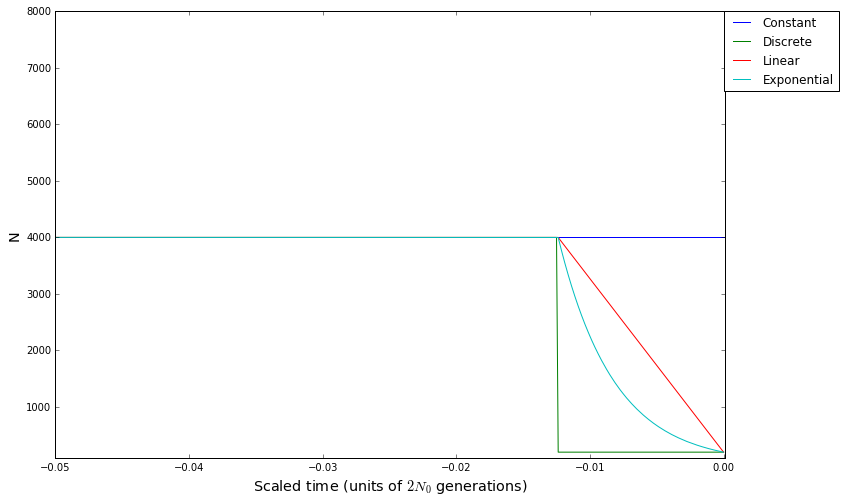

In [44]:
fig=plt.figure(figsize=(12,8))
line1, = plt.plot(scaled_time,const_N,label='Constant')
line2, = plt.plot(scaled_time,bottle_N,label='Discrete')
line3, = plt.plot(scaled_time,decline_N,label='Linear')
line4, = plt.plot(scaled_time,exp_N,label='Exponential')
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size='x-large')
plt.ylabel("N",size='x-large')
plt.xlim(-0.05,0.0001)
plt.ylim(np.min(bottle_N)/2,np.max(const_N)*2)
plt.legend( bbox_to_anchor=(1.17,1),borderaxespad=0.,loc=1)
plt.show()



# Classes for tajima's D and total teleterious mutations

In [3]:
class TajD:
    def __init__(self):
        self.ancestral_tajd = []
        self.const_outcross_tajd = []
        self.bottle_outcross_tajd = []
        self.const_clonal_tajd = []
        self.bottle_clonal_tajd = []
    def __call__(self,pkl_data):
        self.ancestral_tajd = pd.DataFrame([i['ancestral'].total_tajd for i in pkl_data])
        self.const_outcross_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['const_outcross'].total_tajd for 
                  i in pkl_data])],axis=1)
        self.bottle_outcross_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['bottle_outcross'].total_tajd for 
                  i in pkl_data])],axis=1)
        self.const_clonal_tajd = pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['const_clonal'].total_tajd for 
                  i in pkl_data])],axis=1)
        self.bottle_clonal_tajd =pd.concat([self.ancestral_tajd,
        pd.DataFrame([i['bottle_clonal'].total_tajd for 
                  i in pkl_data])],axis=1)
        


In [18]:
def total_muts(recorder):
    total_muts = [i + 2*j for i,j in 
                     zip(recorder.mean_deleterious_per_diploid,
                    recorder.fixed_deleterious)]
    return(total_muts)

class delMut:
    def __init__(self):
        self.ancestral_delmut = []
        self.const_outcross_delmut = []
        self.bottle_outcross_delmut = []
        self.const_clonal_delmut = []
        self.bottle_clonal_delmut = []
    def __call__(self,pkl_data):
        self.ancestral_delmut = pd.DataFrame([total_muts(i['ancestral']) for i in pkl_data])
        self.const_outcross_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['const_outcross']) for 
                  i in pkl_data])],axis=1)
        self.bottle_outcross_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['bottle_outcross']) for 
                  i in pkl_data])],axis=1)
        self.const_clonal_delmut = pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['const_clonal']) for 
                  i in pkl_data])],axis=1)
        self.bottle_clonal_delmut =pd.concat([self.ancestral_delmut,
        pd.DataFrame([total_muts(i['bottle_clonal']) for 
                  i in pkl_data])],axis=1)
        


# Extract summary statistics

In [17]:
add_delmut = delMut()
rec_delmut = delMut()
add_delmut(add_pkl_data)
rec_delmut(rec_pkl_data)

disc_add_delmut = delMut()
disc_rec_delmut = delMut()
disc_add_delmut(disc_add_pkl_data)
disc_rec_delmut(disc_rec_pkl_data)

add_tajd = TajD()
rec_tajd = TajD()
add_tajd(add_pkl_data)
rec_tajd(rec_pkl_data)

disc_add_tajd = TajD()
disc_rec_tajd = TajD()
disc_add_tajd(disc_add_pkl_data)
disc_rec_tajd(disc_rec_pkl_data)


# Full decline plots

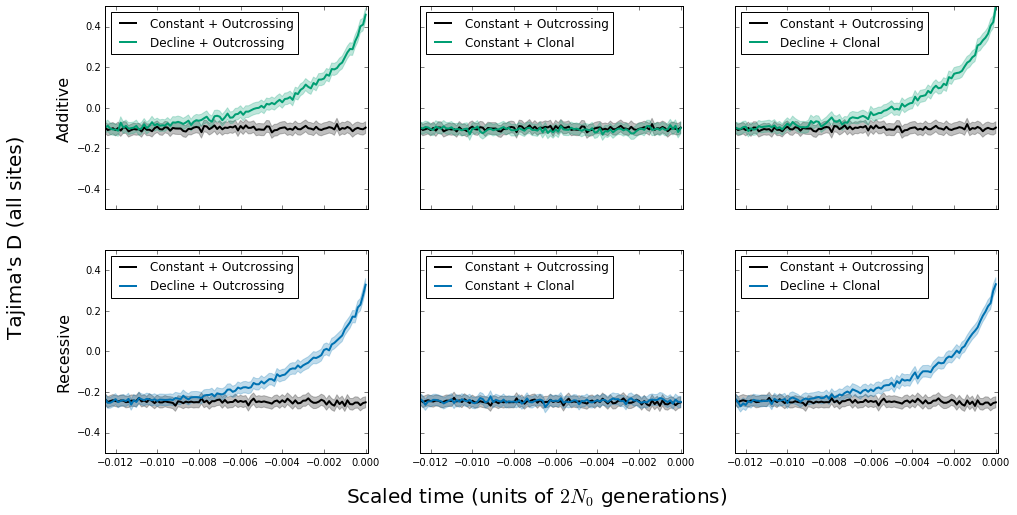

In [123]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=True,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_tajd.bottle_outcross_tajd.mean(),
                 label='Decline + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.bottle_outcross_tajd.mean() - np.sqrt(add_tajd.bottle_outcross_tajd.var()/500),
add_tajd.bottle_outcross_tajd.mean() + np.sqrt(add_tajd.bottle_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_clonal_tajd.mean() - np.sqrt(add_tajd.const_clonal_tajd.var()/500),
add_tajd.const_clonal_tajd.mean() + np.sqrt(add_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_tajd.bottle_clonal_tajd.mean(),
                 label='Decline + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.bottle_clonal_tajd.mean() - np.sqrt(add_tajd.bottle_clonal_tajd.var()/500),
add_tajd.bottle_clonal_tajd.mean() + np.sqrt(add_tajd.bottle_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_tajd.bottle_outcross_tajd.mean(),
                 label='Decline + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.bottle_outcross_tajd.mean() - np.sqrt(rec_tajd.bottle_outcross_tajd.var()/500),
rec_tajd.bottle_outcross_tajd.mean() + np.sqrt(rec_tajd.bottle_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_clonal_tajd.mean() - np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
rec_tajd.const_clonal_tajd.mean() + np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_tajd.bottle_clonal_tajd.mean(),
                 label='Decline + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.bottle_clonal_tajd.mean() - np.sqrt(rec_tajd.bottle_clonal_tajd.var()/500),
rec_tajd.bottle_clonal_tajd.mean() + np.sqrt(rec_tajd.bottle_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

#Global
plt.xlim(-0.0125,0.0001)
plt.ylim(-0.5,0.5)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Tajima's D (all sites)",size=20, va='center', rotation='vertical')
f.savefig('plots/tajd_time_combined.pdf')
plt.show()

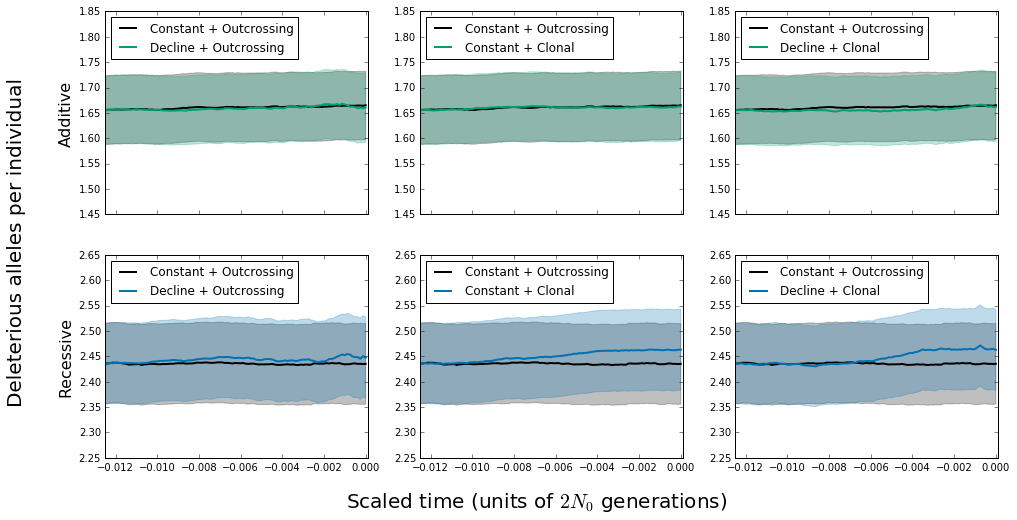

In [126]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_delmut.bottle_outcross_delmut.mean(),
                 label='Decline + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.bottle_outcross_delmut.mean() - np.sqrt(add_delmut.bottle_outcross_delmut.var()/500),
add_delmut.bottle_outcross_delmut.mean() + np.sqrt(add_delmut.bottle_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')
axarr[0,0].set_ylim(1.45,1.85)
#const out vs const clonal
axarr[0,1].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_clonal_delmut.mean() - np.sqrt(add_delmut.const_clonal_delmut.var()/500),
add_delmut.const_clonal_delmut.mean() + np.sqrt(add_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')
axarr[0,1].set_ylim(1.45,1.85)

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_delmut.bottle_clonal_delmut.mean(),
                 label='Decline + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.bottle_clonal_delmut.mean() - np.sqrt(add_delmut.bottle_clonal_delmut.var()/500),
add_delmut.bottle_clonal_delmut.mean() + np.sqrt(add_delmut.bottle_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')
axarr[0,2].set_ylim(1.45,1.85)
#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_delmut.bottle_outcross_delmut.mean(),
                 label='Decline + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.bottle_outcross_delmut.mean() - np.sqrt(rec_delmut.bottle_outcross_delmut.var()/500),
rec_delmut.bottle_outcross_delmut.mean() + np.sqrt(rec_delmut.bottle_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')
axarr[1,0].set_ylim(2.25,2.65)

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_clonal_delmut.mean() - np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
rec_delmut.const_clonal_delmut.mean() + np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
axarr[1,1].set_ylim(2.25,2.65)

#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_delmut.bottle_clonal_delmut.mean(),
                 label='Decline + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.bottle_clonal_delmut.mean() - np.sqrt(rec_delmut.bottle_clonal_delmut.var()/500),
rec_delmut.bottle_clonal_delmut.mean() + np.sqrt(rec_delmut.bottle_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')
axarr[1,2].set_ylim(2.25,2.65)

#Global
plt.xlim(-0.0125,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Deleterious alleles per individual",size=20, va='center', rotation='vertical')
f.savefig('plots/delmut_time_combined.pdf')
plt.show()

# Full discrete plots

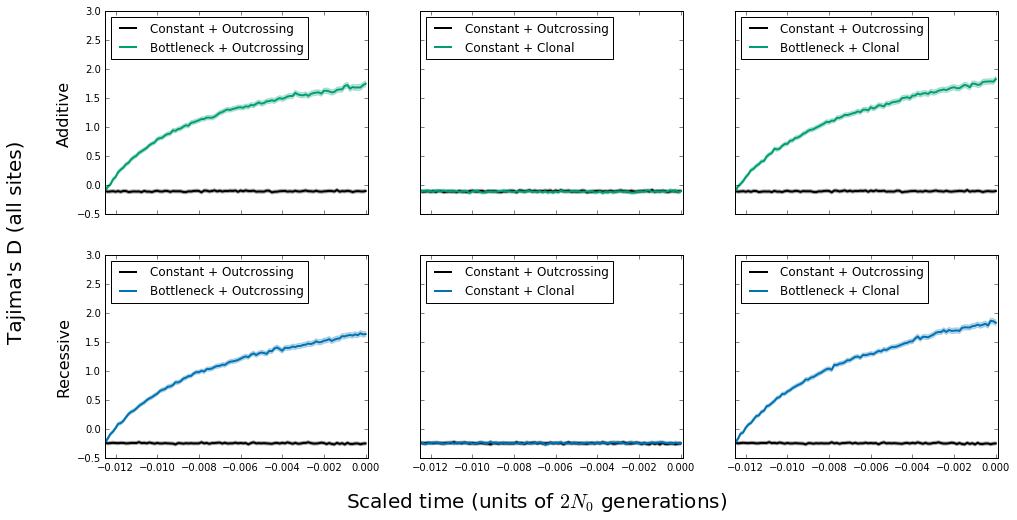

In [130]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=True,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_tajd.bottle_outcross_tajd.mean(),
                 label='Bottleneck + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_tajd.bottle_outcross_tajd.mean() - np.sqrt(add_tajd.bottle_outcross_tajd.var()/500),
add_tajd.bottle_outcross_tajd.mean() + np.sqrt(add_tajd.bottle_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')

#const out vs const clonal
axarr[0,1].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_tajd.const_clonal_tajd.mean() - np.sqrt(add_tajd.const_clonal_tajd.var()/500),
add_tajd.const_clonal_tajd.mean() + np.sqrt(add_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.const_outcross_tajd.mean() - np.sqrt(add_tajd.const_outcross_tajd.var()/500),
add_tajd.const_outcross_tajd.mean() + np.sqrt(add_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_tajd.bottle_clonal_tajd.mean(),
                 label='Bottleneck + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_tajd.bottle_clonal_tajd.mean() - np.sqrt(add_tajd.bottle_clonal_tajd.var()/500),
add_tajd.bottle_clonal_tajd.mean() + np.sqrt(add_tajd.bottle_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_tajd.bottle_outcross_tajd.mean(),
                 label='Bottleneck + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_tajd.bottle_outcross_tajd.mean() - np.sqrt(rec_tajd.bottle_outcross_tajd.var()/500),
rec_tajd.bottle_outcross_tajd.mean() + np.sqrt(rec_tajd.bottle_outcross_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_tajd.const_clonal_tajd.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_tajd.const_clonal_tajd.mean() - np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
rec_tajd.const_clonal_tajd.mean() + np.sqrt(rec_tajd.const_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_tajd.const_outcross_tajd.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.const_outcross_tajd.mean() - np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
rec_tajd.const_outcross_tajd.mean() + np.sqrt(rec_tajd.const_outcross_tajd.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_tajd.bottle_clonal_tajd.mean(),
                 label='Bottleneck + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_tajd.bottle_clonal_tajd.mean() - np.sqrt(rec_tajd.bottle_clonal_tajd.var()/500),
rec_tajd.bottle_clonal_tajd.mean() + np.sqrt(rec_tajd.bottle_clonal_tajd.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')

#Global
plt.xlim(-0.0125,0.0001)
plt.ylim(-0.5,3)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Tajima's D (all sites)",size=20, va='center', rotation='vertical')
f.savefig('plots/disc_tajd_time_combined.pdf')
plt.show()

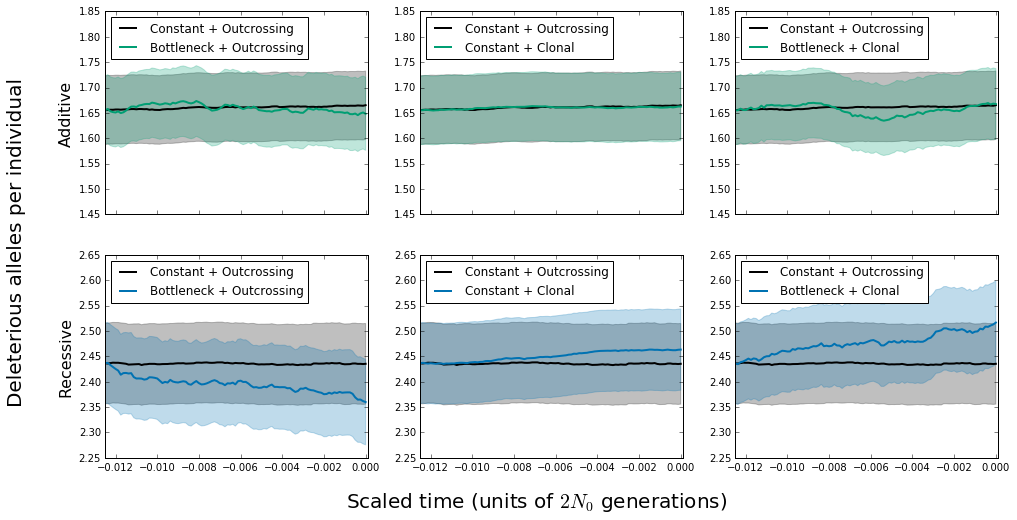

In [131]:
f, axarr = plt.subplots(2,3,sharex=True,sharey=False,figsize=(16,8))
#######Additive
#const out vs bottle out
axarr[0,0].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,0].plot(scaled_time,add_delmut.bottle_outcross_delmut.mean(),
                 label='Bottleneck + Outcrossing',
                 color="#009E73",
                lw=2)
axarr[0,0].fill_between(scaled_time, 
add_delmut.bottle_outcross_delmut.mean() - np.sqrt(add_delmut.bottle_outcross_delmut.var()/500),
add_delmut.bottle_outcross_delmut.mean() + np.sqrt(add_delmut.bottle_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,0].set_ylabel("Additive",size=16)
axarr[0,0].legend(loc='upper left')
axarr[0,0].set_ylim(1.45,1.85)
#const out vs const clonal
axarr[0,1].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,1].plot(scaled_time,add_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,1].fill_between(scaled_time, 
add_delmut.const_clonal_delmut.mean() - np.sqrt(add_delmut.const_clonal_delmut.var()/500),
add_delmut.const_clonal_delmut.mean() + np.sqrt(add_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,1].legend(loc='upper left')
axarr[0,1].set_ylim(1.45,1.85)

#const out vs bottle clonal
axarr[0,2].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.const_outcross_delmut.mean() - np.sqrt(add_delmut.const_outcross_delmut.var()/500),
add_delmut.const_outcross_delmut.mean() + np.sqrt(add_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[0,2].plot(scaled_time,add_delmut.bottle_clonal_delmut.mean(),
                 label='Bottleneck + Clonal',
                 color="#009E73",
                lw=2)
axarr[0,2].fill_between(scaled_time, 
add_delmut.bottle_clonal_delmut.mean() - np.sqrt(add_delmut.bottle_clonal_delmut.var()/500),
add_delmut.bottle_clonal_delmut.mean() + np.sqrt(add_delmut.bottle_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#009E73",facecolor='#009E73')

axarr[0,2].legend(loc='upper left')
axarr[0,2].set_ylim(1.45,1.85)

#######Recessive
#const out vs bottle out
axarr[1,0].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,0].plot(scaled_time,rec_delmut.bottle_outcross_delmut.mean(),
                 label='Bottleneck + Outcrossing',
                 color="#0072B2",
                lw=2)
axarr[1,0].fill_between(scaled_time, 
rec_delmut.bottle_outcross_delmut.mean() - np.sqrt(rec_delmut.bottle_outcross_delmut.var()/500),
rec_delmut.bottle_outcross_delmut.mean() + np.sqrt(rec_delmut.bottle_outcross_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,0].set_ylabel("Recessive",size=16)
axarr[1,0].legend(loc='upper left')
axarr[1,0].set_ylim(2.25,2.65)

#const out vs const clonal
axarr[1,1].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)

axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,1].plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Constant + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,1].fill_between(scaled_time, 
rec_delmut.const_clonal_delmut.mean() - np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
rec_delmut.const_clonal_delmut.mean() + np.sqrt(rec_delmut.const_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')

axarr[1,1].legend(loc='upper left')
axarr[1,1].set_ylim(2.25,2.65)

#const out vs bottle clonal
axarr[1,2].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Constant + Outcrossing',
                 color="#000000",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.const_outcross_delmut.mean() - np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
rec_delmut.const_outcross_delmut.mean() + np.sqrt(rec_delmut.const_outcross_delmut.var()/500),
    alpha=0.25,edgecolor="#000000",facecolor='#000000')

axarr[1,2].plot(scaled_time,rec_delmut.bottle_clonal_delmut.mean(),
                 label='Bottleneck + Clonal',
                 color="#0072B2",
                lw=2)
axarr[1,2].fill_between(scaled_time, 
rec_delmut.bottle_clonal_delmut.mean() - np.sqrt(rec_delmut.bottle_clonal_delmut.var()/500),
rec_delmut.bottle_clonal_delmut.mean() + np.sqrt(rec_delmut.bottle_clonal_delmut.var()/500),
    alpha=0.25 ,edgecolor="#0072B2",facecolor='#0072B2')
axarr[1,2].legend(loc='upper left')# bbox_to_anchor=(1.3, 1),borderaxespad=0.,loc=1
axarr[1,2].set_ylim(2.25,2.65)

#Global
plt.xlim(-0.0125,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=20, ha='center')
f.text(0.04, 0.5, "Deleterious alleles per individual",size=20, va='center', rotation='vertical')
f.savefig('plots/disc_delmut_time_combined.pdf')
plt.show()

# Combined deleterious mutations plot

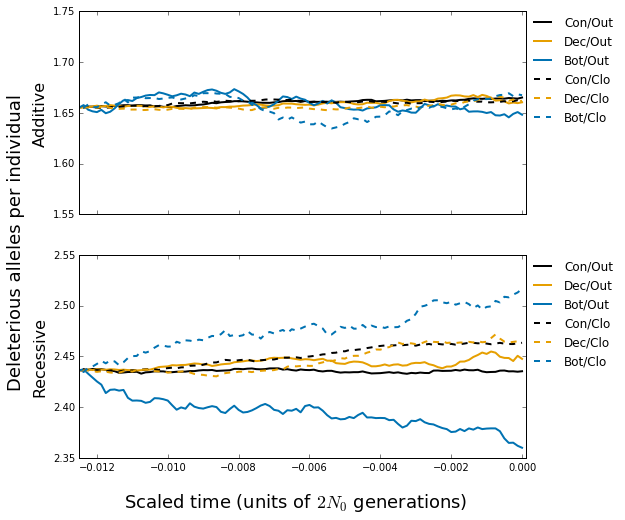

In [29]:
f, axarr = plt.subplots(2,1,sharex=True,sharey=False,figsize=(8,8))
#######Additive
#const out vs bottle out
axarr[0].plot(scaled_time,add_delmut.const_outcross_delmut.mean(),
                 label='Con/Out',
                 color="#000000",
                lw=2,
             linestyle='solid')

axarr[0].plot(scaled_time,add_delmut.bottle_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')

axarr[0].plot(scaled_time,disc_add_delmut.bottle_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

axarr[0].plot(scaled_time,add_delmut.const_clonal_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

axarr[0].plot(scaled_time,add_delmut.bottle_clonal_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')

axarr[0].plot(scaled_time,disc_add_delmut.bottle_clonal_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')

axarr[0].set_ylabel("Additive",size=16)
axarr[0].legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
axarr[0].set_ylim(1.55,1.75)
#const out vs const clonal

#######Recessive
#const out vs bottle out
axarr[1].plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Con/Out',
                 color="#000000",
                lw=2,
             linestyle='solid')

axarr[1].plot(scaled_time,rec_delmut.bottle_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')

axarr[1].plot(scaled_time,disc_rec_delmut.bottle_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

axarr[1].plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

axarr[1].plot(scaled_time,rec_delmut.bottle_clonal_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')

axarr[1].plot(scaled_time,disc_rec_delmut.bottle_clonal_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')

axarr[1].set_ylabel("Recessive",size=16)
axarr[1].legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
axarr[1].set_ylim(2.35,2.55)

#Global
plt.xlim(-0.0125,0.0001)
f.text(0.5, 0.04, r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18, ha='center')
f.text(0, 0.5, "Deleterious alleles per individual",size=18, va='center', rotation='vertical')
f.savefig('plots/all_delmut_time_combined.pdf',bbox_inches='tight')
plt.show()

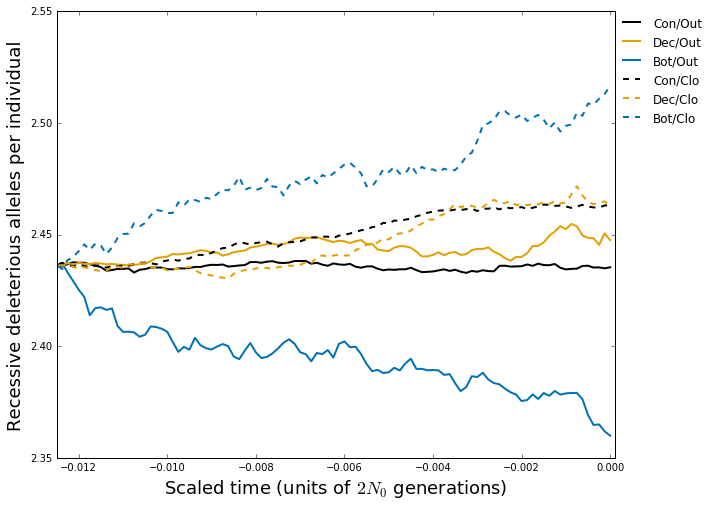

In [35]:
fig= plt.figure(figsize=(10,8))

#######Recessive
#const out vs bottle out
f1, = plt.plot(scaled_time,rec_delmut.const_outcross_delmut.mean(),
                 label='Con/Out',
                 color="#000000",
                lw=2,
             linestyle='solid')

f2, = plt.plot(scaled_time,rec_delmut.bottle_outcross_delmut.mean(),
                 label='Dec/Out',
                 color="#E69F00",
                lw=2,
             linestyle='solid')

f3, = plt.plot(scaled_time,disc_rec_delmut.bottle_outcross_delmut.mean(),
                 label='Bot/Out',
                 color="#0072B2",
                lw=2,
             linestyle='solid')

f4, = plt.plot(scaled_time,rec_delmut.const_clonal_delmut.mean(),
                 label='Con/Clo',
                 color="#000000",
                lw=2,
             linestyle='dashed')

f5, = plt.plot(scaled_time,rec_delmut.bottle_clonal_delmut.mean(),
                 label='Dec/Clo',
                 color="#E69F00",
                lw=2,
             linestyle='dashed')

f6, = plt.plot(scaled_time,disc_rec_delmut.bottle_clonal_delmut.mean(),
                 label='Bot/Clo',
                 color="#0072B2",
                lw=2,
             linestyle='dashed')




plt.ylabel("Recessive deleterious alleles per individual",size=18)
plt.xlabel(r'Scaled time (units of '+r'$2N_0$'+" generations)",size=18)
plt.legend(bbox_to_anchor=(1, 1),borderaxespad=0,loc=2,frameon=False)
plt.ylim(2.35,2.55)

#Global
plt.xlim(-0.0125,0.0001)
fig.savefig('plots/rec_delmut_time_combined.pdf',bbox_inches='tight')
plt.show()